In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# Voting Classifiers

In [3]:
from sklearn.ensemble import VotingClassifier

In [4]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc',SVC(random_state=42))
])

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

The voting classifier clones every estimator passed into it and then fits the clones. The original estimators are available via estimators/named_estimators attribute. The fitted clones are available via estimators_/named_estimators_ attribute.

In [5]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, ' = ', clf.score(X_test,y_test))

lr  =  0.864
rf  =  0.896
svc  =  0.896


### It performs <b><u>hard voting</b></u> by default ie. it outputs the result that the majority votes.

In [6]:
print(voting_clf.predict(X_test[:1]))
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[1]


[array([1]), array([1]), array([0])]

As you can see that the score by the voting classifier is significantly better than the individual estimators.

In [7]:
voting_clf.score(X_test, y_test)

0.912

### <b><u>Soft voting</u></b> entails combining the probabilities of each prediction in each model and picking the prediction with the highest total probability

In [8]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True

voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting

Another  approach  is  to  use  the  same  training  algorithm  for  every
predictor  but  train  them  on  different  random  subsets  of  the  training  set.  When
sampling  is  performed  with  replacement,  this  method  is  called  bagging  (short  for
bootstrap aggregating). When sampling is performed without replacement, it is called
pasting.


For final prediction, the ensemble uses mode for classification and average for classification on the predictions of all predictors.

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, 
                            n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

For pasting, set hyperparameter, 'bootstrap' to False. Default is True.

### Out-of-Bag Evaluation

It  can  be  shown  mathematically  that  only  about  63%  of  the  training  instances  are  sampled  on  average  for  each  predictor by the bagging process. If  there  are  enough  estimators,  then  each  instance in  the  training  set  will  likely  be  an  OOB  instance  of  several  estimators. <br><br>

Hence if we use oob instances, we do not need a separate validation set.

In [10]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, n_jobs=-1, 
                            random_state=42, oob_score=True)

bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)
print(bag_clf.score(X_test, y_test))

0.896
0.92


The values are quite similar! With the oob_decision_function_ attribute, you can find estimates for the training instances.

In [11]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

### Sampling features instead of instances

Baggy Classifier supports sampling the features as well. They are controlled by 'max_features' and 'bootstrap_features'. They work the same as 'max_samples' and 'bootstrap'. This trick is useful for high-dimensional data.<br><br>

Sampling both instances and features is called <b><u>random patches method</b></u>.<br>
Keeping all training instance (bootstrap = False, max_samples=1.0) and sampling features (bootstrap_features = True, max_features < 1.0) is called <b><u>random subspaces method</b></u>.

# Random Forests

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can use RandomForestClassifier.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)

If we set the 'max_features' attribute to 'sqrt' in the BaggingClassifier, it will be equivalent to RandomForestClassifier as it samples n**0.5 features.

### Extra-Trees

In the DecisionTreeClassifier, set hyperparameter, 'splitter' to <b>random</b> instead of <b>best</b>. It is to make trees even more random by using random thresholds for each feature rather than
searching  for  the  best  possible  thresholds. <br><br>

Create ExtraTreesClassifier using Scikit Learn's class.

### Feature Importance

Feature importance is measured by how much the nodes that uses this feature reduces impurity on average. It is a weighted average where the weight is the number of training samples that are associated with it.

Get important features with the feature_importances_ attribute and get the respective feature names from columns attribute.

# Boosting

The main intuition of boosting is to train predictors sequentially, where each predictor tries to solve the errors made by predecessors.

### AdaBoost

The algorithm at each iteration tries to predict on the training set and increases the weight for the misclassified data.

In [13]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 30, 
                             learning_rate = 0.5, random_state = 42)

If it is overfitting, try reducing number of estimators or strongly regularize the base estimator.

### Gradient Boosting

Instead of tweaking and updating the weights of the instances at each iteration, it instead tries to fit a new predictor based on the residual errors made in previous iterations.<br><br>

Residual errors means the original values of y in the previous iteration minus the predicated values of y.

array([0.49484029])

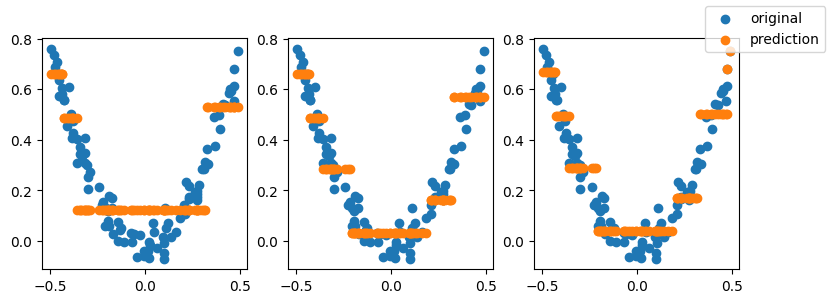

In [18]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100,1) - 0.5

tree_reg_1 = DecisionTreeRegressor(max_depth=2, random_state=42)
y1 = 3 * X[:,0] ** 2 + 0.05 * np.random.randn(100)
tree_reg_1.fit(X, y1)
pred_1 = tree_reg_1.predict(X)

tree_reg_2 = DecisionTreeRegressor(max_depth=2, random_state=43)
y2 = y1 - pred_1
tree_reg_2.fit(X, y2)
pred_2 = tree_reg_2.predict(X)

tree_reg_3 = DecisionTreeRegressor(max_depth=2, random_state=44)
y3 = y2 - pred_2
tree_reg_3.fit(X, y3)
pred_3 = tree_reg_3.predict(X)


fig, ax = plt.subplots(figsize = (9,3), nrows=1, ncols=3)
ax[0].scatter(X, y1, label = 'original')
ax[0].scatter(X, pred_1, label = 'prediction')
ax[1].scatter(X, y1)
ax[1].scatter(X, pred_1 + pred_2)
ax[2].scatter(X, y1)
ax[2].scatter(X, pred_1 + pred_2 + pred_3)
fig.legend()

pred_rand = tree_reg_1.predict([[-0.4]])+tree_reg_2.predict([[-0.4]])+tree_reg_3.predict([[-0.4]])
pred_rand

The equivalent to the above ensemble is as follows:

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42, max_depth=2, n_estimators=3, learning_rate=1)
gbr.fit(X, y1)
gbr.predict([[-0.4]])

array([0.49484029])

Hyperparameters for GradientBoostingRegressor:<br><br>

n_iter_no_change = for early stopping<br>
validation_fraction = when n_iter_no_change is set, the data is split for validation<br>
tol = maximum performance improvement that still counts as negligible<br><br>

subsample = fraction of training data, selected randomly, to be used for training each tree. (setting this results in stochastic gradient boosting which leads to lower variance)

### Histogram-based gradient boosting

This method bins the input features, replacing them with integers and this can be set from the hyperparameter 'max_bins'. This regressor does not require scaling, imputing or one-hot encoding and works well with missing values as well. All it needs is encoding of the categorical features which can be performed with help of OrdinalEncoder().

Hyperparameters for HistGradientBoostingClassifier:<br><br>

early_stopping: Automatically activated if no of instances > 10000<br>
max_iter: no of estimators<br>
max_leaf_nodes, min_samples_leaf, max_depth: some decision tree hyperparameters

In [35]:
import pandas as pd
housing = pd.read_csv('datasets/housing/housing.csv')

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)


from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ['ocean_proximity']), remainder = 'passthrough', force_int_remainder_cols=False),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)

hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [56]:
hgb_reg[1].is_categorical_

array([ True, False, False, False, False, False, False, False, False])

### There are other optimized implementations of gradient boosting available such as XGBoost, CatBoost and LightGBM.

# Stacking

Instead of using hard/soft voting aggregating methods, we pass the predictions of each estimator to a blender/meta learner which is our final predictor. You may also put a layer of blenders such as linear, svm etc and then put another blender on top of that. However, that might be going for the overkill!<br><br>

You may use cross_val_predict on the estimators to build our blender training set and the targets will be from the original dataset.<br><br>



In [57]:
from sklearn.ensemble import StackingClassifier

stack_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5
)

By default, StackingClassifier will use LogisticRegression and StackingRegressor will use RidgeCV if no estimators are mentioned.